### Zespół 4:
- Jakub Smuga
- Konrad Korus
- Maksym Kazhaiev

## Imports



In [ ]:
!pip install SALib

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from SALib.sample import sobol as sobol_sample
from SALib.analyze import sobol
from SALib.analyze import pawn
from SALib.sample import saltelli
from scipy.stats import ks_2samp
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.utils import shuffle
import time
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing

In [ ]:
from enum import Enum

class AnalysisMethod(Enum):
    SOBOL = "Sobol"
    PAWN = "Pawn"

## Helper functions

In [ ]:
random_shuffle_state = 2024

def train_valid_test_split(features, targets, valid_p = 0.1, test_p = 0.3):
  # shuffle the features and targets in the same way
  features = shuffle(features, random_state = random_shuffle_state)
  targets = shuffle(targets, random_state = random_shuffle_state)
  train_size = int(len(features) * (1 - (test_p + valid_p)))
  valid_size = int(len(features) * valid_p)

  X_train, X_valid, X_test = features[:train_size], features[train_size:train_size + valid_size], features[train_size + valid_size:]
  y_train, y_valid, y_test = targets[:train_size], targets[train_size:train_size + valid_size], targets[train_size + valid_size:]
  return (X_train, y_train, X_valid, y_valid, X_test, y_test)

In [ ]:
def plot_accuracy(removed_inputs_history, train_accuracy_history, valid_accuracy_history, test_accuracy_history):
    if removed_inputs_history == None:
        removed_inputs_history = range(len(train_accuracy_history))

    plt.figure(figsize=(10, 6))

    plt.plot(removed_inputs_history, train_accuracy_history, marker='o', linestyle='-', color='b', label='Train Accuracy')
    plt.plot(removed_inputs_history, valid_accuracy_history, marker='s', linestyle='-', color='g', label='Validation Accuracy')
    plt.plot(removed_inputs_history, test_accuracy_history, marker='^', linestyle='-', color='r', label='Test Accuracy')

    plt.xlabel('Removed Input History')
    plt.ylabel('Accuracy')
    plt.title('Accuracy during removal of features')
    plt.legend()

    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
def plot_time(removed_inputs_history, time_history):
    if removed_inputs_history == None:
        removed_inputs_history = range(len(time_history))

    plt.figure(figsize=(10, 6))

    plt.plot(removed_inputs_history, time_history, label='Time')

    plt.xlabel('Removed Input History')
    plt.ylabel('Time')
    plt.title('Time during removal of features')
    plt.legend()

    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
def plot_analysis(removed_inputs_history, analysis_history, average_analysis_history, label):
    if removed_inputs_history == None:
        removed_inputs_history = range(len(analysis_history))

    plt.figure(figsize=(10, 6))

    plt.plot(removed_inputs_history, analysis_history, label=f"{label} analysis value for removed neuron")
    plt.plot(removed_inputs_history, average_analysis_history, label=f"{label} Average analysis value")

    plt.xlabel('Removed Input History')
    plt.ylabel('Analysis')
    plt.title(f'{label} Analysis during removal of features')
    plt.legend()

    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
def plot_loss(removed_inputs_history, loss_history):
    if removed_inputs_history == None:
        removed_inputs_history = range(len(loss_history))

    plt.figure(figsize=(10, 6))

    plt.plot(removed_inputs_history, loss_history, label='Loss')

    plt.xlabel('Removed Input History')
    plt.ylabel('Loss')
    plt.title('Loss during removal of features')
    plt.legend()

    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
def save_model(model, filename):
    torch.save(model.state_dict(), filename)

def load_model(model, filename):
    model.load_state_dict(torch.load(filename))

##First Layer

In [ ]:
# Definicja modelu MLP
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLP, self).__init__()
        self.linear1 = nn.Linear(input_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)
        self.linear3 = nn.Linear(hidden_dim, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.linear1(x)
        X = self.relu(x)
        x = self.linear2(x)
        X = self.dropout(x)
        x = self.linear3(x)
        return x

In [ ]:
def trainAndGetLowestAnalysisValueForFirstLayer (model, X_train_tensor, y_train_tensor, X_valid_tensor, y_valid_tensor,  X_test_tensor, y_test_tensor, analysis_method, columns):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    epochs = 10
    batch_size = 16

    problem = {
        'num_vars':  X_train_tensor.shape[1],
        'names': [f'x{i+1}' for i in range( X_train_tensor.shape[1])],
        'bounds': [[0, 1]] *  X_train_tensor.shape[1]
    }

    learning_time_start = time.time()
    for epoch in range(epochs):
        for i in range(0, len(X_train_tensor), batch_size):
            inputs = X_train_tensor[i:i+batch_size]
            labels = y_train_tensor[i:i+batch_size]

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels.unsqueeze(1))
            loss.backward()
            optimizer.step()

        with torch.no_grad():
            outputs = model(X_train_tensor)
            _, predicted = torch.max(outputs, 1)
            train_accuracy = (predicted == y_train_tensor).sum().item() / len(y_train_tensor)

            outputs = model(X_valid_tensor)
            _, predicted = torch.max(outputs, 1)
            valid_accuracy = (predicted == y_valid_tensor).sum().item() / len(y_valid_tensor)

            outputs = model(X_test_tensor)
            _, predicted = torch.max(outputs, 1)
            test_accuracy = (predicted == y_test_tensor).sum().item() / len(y_test_tensor)

            print(f"Loss: {loss.item():.4f}, Training Accuracy: {train_accuracy:.4f}, Valid Accuracy: {valid_accuracy:.4f}, , Test Accuracy: {test_accuracy:.4f}")
            if epoch == epochs - 1:
                learning_time = time.time() - learning_time_start;

                param_values = sobol_sample.sample(problem, 1024)
                param_tensor = torch.tensor(param_values, dtype=torch.float32)

                if analysis_method == AnalysisMethod.SOBOL:
                  Y = model(param_tensor).detach().numpy().flatten()
                  Si = sobol.analyze(problem, Y, print_to_console=False)
                  min_sobol_index=np.argmin(Si['S1'])
                  avarage_value=np.mean(Si['S1'])
                  print(f"[Sobol] Dropping neuron with index {min_sobol_index} (column: {columns[min_sobol_index]}) |  Sobol value =  {Si['S1'][min_sobol_index]:.5f} | Avg Sobol value: {avarage_value:.5f}")
                  return min_sobol_index, train_accuracy, valid_accuracy, test_accuracy, learning_time, Si['S1'][min_sobol_index], avarage_value, loss.item()

                elif analysis_method == AnalysisMethod.PAWN:
                  Y = model(param_tensor)
                  _, Y = torch.max(Y, 1)
                  Si = pawn.analyze(problem, param_values, Y, print_to_console=False)
                  min_pawn_index=np.argmin(Si['median'])
                  avarage_value=np.mean(Si['median'])
                  print(f"[PAWN] Dropping neuron with index {min_pawn_index} (column: {columns[min_pawn_index]}) |  PAWN value =  {Si['CV'][min_pawn_index]:.5f} | Avg PAWN value: {avarage_value:.5f} ")
                  return  min_pawn_index, train_accuracy, valid_accuracy, test_accuracy, learning_time, Si['CV'][min_pawn_index], avarage_value, loss.item()

                else:
                  print("Wrong analysis method!")


def trainWhileRemovingInputsBasedOnAnalysisForFirstLayer (X, y, hiddden_dim, analysis_method):
    removed_inputs_history = []
    train_accuracy_history = []
    valid_accuracy_history = []
    test_accuracy_history = []
    time_history = []
    analysis_history = []
    average_analysis_history = []
    loss_history = []

    for trainIndex in range(len(X.columns)):
        print(f"---------------------------------------- Iteration {trainIndex+1} ----------------------------------------")
        label_encoder = LabelEncoder()
        y = label_encoder.fit_transform(y)

        X_train, y_train, X_valid, y_valid, X_test, y_test = train_valid_test_split(X, y)

        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_valid = scaler.transform(X_valid)
        X_test = scaler.transform(X_test)

        X_train_tensor = torch.tensor(X_train, dtype=torch.float)
        y_train_tensor = torch.tensor(y_train, dtype=torch.float)
        X_valid_tensor = torch.tensor(X_valid, dtype=torch.float)
        y_valid_tensor = torch.tensor(y_valid, dtype=torch.float)
        X_test_tensor = torch.tensor(X_test, dtype=torch.float)
        y_test_tensor = torch.tensor(y_test, dtype=torch.float)

        input_dim = X_train_tensor.shape[1]
        output_dim = len(np.unique(y_train))
        model = MLP(input_dim, hidden_dim, output_dim)

        removed_input, train_accureacy, valid_accuracy, test_accuracy, time, analysis_value, average_analysis_value, loss = trainAndGetLowestAnalysisValueForFirstLayer(model, X_train_tensor, y_train_tensor, X_valid_tensor, y_valid_tensor, X_test_tensor, y_test_tensor, analysis_method, X.columns)
        removed_inputs_history.append(X.columns[removed_input])
        train_accuracy_history.append(train_accureacy)
        valid_accuracy_history.append(valid_accuracy)
        test_accuracy_history.append(test_accuracy)
        time_history.append(time)
        analysis_history.append(analysis_value)
        average_analysis_history.append(average_analysis_value)
        loss_history.append(loss)

        X = X.drop(X.columns[removed_input], axis=1)
        print("")


    return removed_inputs_history, train_accuracy_history, valid_accuracy_history, test_accuracy_history, time_history, analysis_history, average_analysis_history, loss_history

## Second Layer


In [ ]:
# Definicja modelu MLP
class MLP2(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLP2, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)
        self.linear3 = nn.Linear(hidden_dim, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.linear2(x)
        X = self.dropout(x)
        x = self.linear3(x)
        return x

# Definicja modelu MLP
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLP, self).__init__()
        self.linear1 = nn.Linear(input_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)
        self.linear3 = nn.Linear(hidden_dim, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.linear1(x)
        X = self.relu(x)
        x = self.linear2(x)
        X = self.dropout(x)
        x = self.linear3(x)
        return x

In [ ]:
def trainAndGetLowestAnalysisValueForSecondLayer (model, X_train_tensor, y_train_tensor, X_valid_tensor, y_valid_tensor, X_test_tensor, y_test_tensor, dim, analysis_method):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    epochs = 10
    batch_size = 32

    problem = {
        'num_vars': dim,
        'names': [i for i in range(dim)],
        'bounds': [[0, 1]] * dim
    }

    bounds = np.array([[0, 1]] * dim)

    learning_time_start = time.time()
    for epoch in range(epochs):

        for i in range(0, len(X_train_tensor), batch_size):
            inputs = model.relu(model.fc1(X_train_tensor[i:i+batch_size]))
            labels = y_train_tensor[i:i+batch_size]

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels.unsqueeze(1))
            loss.backward()
            optimizer.step()

        with torch.no_grad():
            outputs = model(model.relu(model.fc1(X_train_tensor)))
            _, predicted = torch.max(outputs, 1)
            train_accuracy = (predicted == y_train_tensor).sum().item() / len(y_train_tensor)

            outputs = model(model.relu(model.fc1(X_valid_tensor)))
            _, predicted = torch.max(outputs, 1)
            valid_accuracy = (predicted == y_valid_tensor).sum().item() / len(y_valid_tensor)

            outputs = model(model.relu(model.fc1(X_test_tensor)))
            _, predicted = torch.max(outputs, 1)
            test_accuracy = (predicted == y_test_tensor).sum().item() / len(y_test_tensor)


            if epoch == epochs - 1:
                learning_time = time.time() - learning_time_start;
                print(f"Loss: {loss.item():.4f}, Training Accuracy: {train_accuracy:.4f}, Valid Accuracy: {valid_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}")

                param_values = sobol_sample.sample(problem, 1024)
                param_tensor = torch.tensor(param_values, dtype=torch.float32)

                if analysis_method == AnalysisMethod.SOBOL:
                  Y = model(param_tensor).detach().numpy().flatten()
                  Si = sobol.analyze(problem, Y, print_to_console=False)
                  min_sobol_index=np.argmin(Si['S1'])
                  avarage_value=np.mean(Si['S1'])
                  print(f"[Sobol] Dropping neuron with index {min_sobol_index} |  Sobol value =  {Si['S1'][min_sobol_index]:.5f} | Avg Sobol value: {avarage_value:.5f}")
                  return min_sobol_index, train_accuracy, valid_accuracy, test_accuracy, learning_time, Si['S1'][min_sobol_index], avarage_value

                elif analysis_method == AnalysisMethod.PAWN:
                  Y = model(param_tensor)
                  _, Y = torch.max(Y, 1)
                  Si = pawn.analyze(problem, param_values, Y, print_to_console=False)
                  min_pawn_index=np.argmin(Si['median'])
                  avarage_value=np.mean(Si['median'])
                  print(f"[PAWN] Dropping neuron with index {min_pawn_index} |  PAWN value =  {Si['median'][min_pawn_index]:.5f} | Avg PAWN value: {avarage_value:.5f} ")
                  return  min_pawn_index, train_accuracy, valid_accuracy, test_accuracy, learning_time, min_pawn_index, avarage_value

                else:
                  print("Wrong analysis method!")

def trainWhileRemovingInputsBasedOnAnalysisForSecondLayer (X, y, hidden_dim, analysis_method):
    removed_inputs_history = []
    train_accuracy_history = []
    valid_accuracy_history = []
    test_accuracy_history = []
    time_history = []
    analysis_history = []
    average_analysis_history = []

    for trainIndex in range(hidden_dim):

        print(f"---------------------------------------- Iteration {trainIndex+1} ----------------------------------------")
        label_encoder = LabelEncoder()
        y = label_encoder.fit_transform(y)

        X_train, y_train, X_valid, y_valid, X_test, y_test = train_valid_test_split(X, y)

        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_valid = scaler.transform(X_valid)
        X_test = scaler.transform(X_test)

        X_train_tensor = torch.tensor(X_train, dtype=torch.float)
        y_train_tensor = torch.tensor(y_train, dtype=torch.float)
        X_valid_tensor = torch.tensor(X_valid, dtype=torch.float)
        y_valid_tensor = torch.tensor(y_valid, dtype=torch.float)
        X_test_tensor = torch.tensor(X_test, dtype=torch.float)
        y_test_tensor = torch.tensor(y_test, dtype=torch.float)

        input_dim = X_train_tensor.shape[1]
        output_dim = len(np.unique(y_train))
        model = MLP2(input_dim, hidden_dim, output_dim)

        removed_input, train_accureacy, valid_accuracy, test_accuracy, time, analysis_value, average_analysis_value = trainAndGetLowestAnalysisValueForSecondLayer(model, X_train_tensor, y_train_tensor, X_valid_tensor, y_valid_tensor, X_test_tensor, y_test_tensor, hidden_dim, analysis_method)
        removed_inputs_history.append(removed_input)
        train_accuracy_history.append(train_accureacy)
        valid_accuracy_history.append(valid_accuracy)
        test_accuracy_history.append(test_accuracy)
        time_history.append(time)
        analysis_history.append(analysis_value)
        average_analysis_history.append(average_analysis_value)

        hidden_dim -= 1
        print("")

    return removed_inputs_history, train_accuracy_history, valid_accuracy_history, test_accuracy_history, time_history, analysis_history, average_analysis_history

## Usuwanie neuronów z pierwszej warstwy - SOBOL

In [ ]:
# !kaggle datasets download -d camnugent/california-housing-prices
# !unzip california-housing-prices.zip

# data = pd.read_csv('housing.csv')
# data = data.drop('ocean_proximity', axis=1) # dont  use this column

# X = data.drop('median_house_value', axis=1)
# y = data['median_house_value']

# housing = fetch_california_housing()

X = pd.DataFrame(housing.data, columns=housing.feature_names)
y = pd.DataFrame(housing.target, columns=housing.target_names)

hidden_dim = 64
removed_inputs_history_first_sobol, train_accuracy_history_first_sobol, valid_accuracy_history_first_sobol, test_accuracy_history_first_sobol, time_history_first_sobol, analysis_history_first_sobol, average_analysis_history_first_sobol, loss_history = trainWhileRemovingInputsBasedOnAnalysisForFirstLayer(X, y, hidden_dim, AnalysisMethod.SOBOL)

---------------------------------------- Iteration 1 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Loss: 365300.1250, Training Accuracy: 0.0001, Valid Accuracy: 0.0000, , Test Accuracy: 0.0005
Loss: 324645.9375, Training Accuracy: 0.0001, Valid Accuracy: 0.0000, , Test Accuracy: 0.0005
Loss: 315176.7500, Training Accuracy: 0.0001, Valid Accuracy: 0.0000, , Test Accuracy: 0.0005
Loss: 311309.7188, Training Accuracy: 0.0001, Valid Accuracy: 0.0000, , Test Accuracy: 0.0005
Loss: 310280.8438, Training Accuracy: 0.0001, Valid Accuracy: 0.0000, , Test Accuracy: 0.0005
Loss: 310655.0312, Training Accuracy: 0.0001, Valid Accuracy: 0.0000, , Test Accuracy: 0.0005
Loss: 311454.8750, Training Accuracy: 0.0001, Valid Accuracy: 0.0000, , Test Accuracy: 0.0005
Loss: 312051.2500, Training Accuracy: 0.0001, Valid Accuracy: 0.0000, , Test Accuracy: 0.0005
Loss: 312262.0938, Training Accuracy: 0.0001, Valid Accuracy: 0.0000, , Test Accuracy: 0.0005
Loss: 312214.2188, Training Accuracy: 0.0001, Valid Accuracy: 0.0000, , Test Accuracy: 0.0005
[Sobol] Dropping neuron with index 4 (column: Population) | 

removed_inputs_history:
['Population', 'AveOccup', 'HouseAge', 'AveRooms', 'AveBedrms', 'MedInc', 'Longitude', 'Latitude']
train_accuracy_history:
[8.074935400516796e-05, 8.074935400516796e-05, 8.074935400516796e-05, 8.074935400516796e-05, 8.074935400516796e-05, 8.074935400516796e-05, 8.074935400516796e-05, 8.074935400516796e-05]
valid_accuracy_history:
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
test_accuracy_history:
[0.00048449612403100775, 0.00048449612403100775, 0.00048449612403100775, 0.00048449612403100775, 0.00048449612403100775, 0.00048449612403100775, 0.00048449612403100775, 0.00048449612403100775]
time_history:
[12.253028869628906, 11.801122903823853, 14.08483624458313, 12.146606683731079, 11.918051958084106, 11.20955753326416, 11.767457723617554, 11.806965589523315]


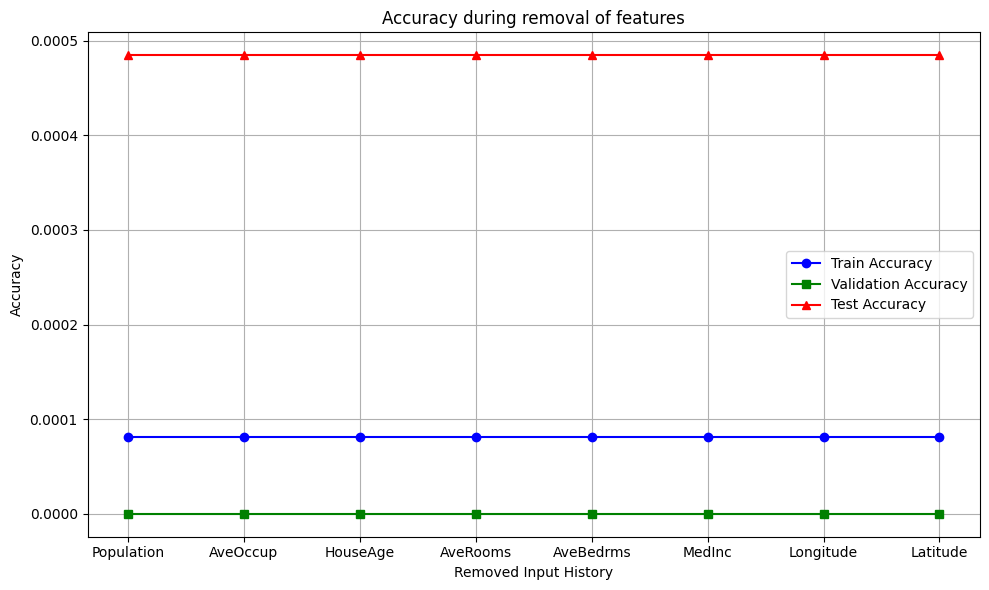

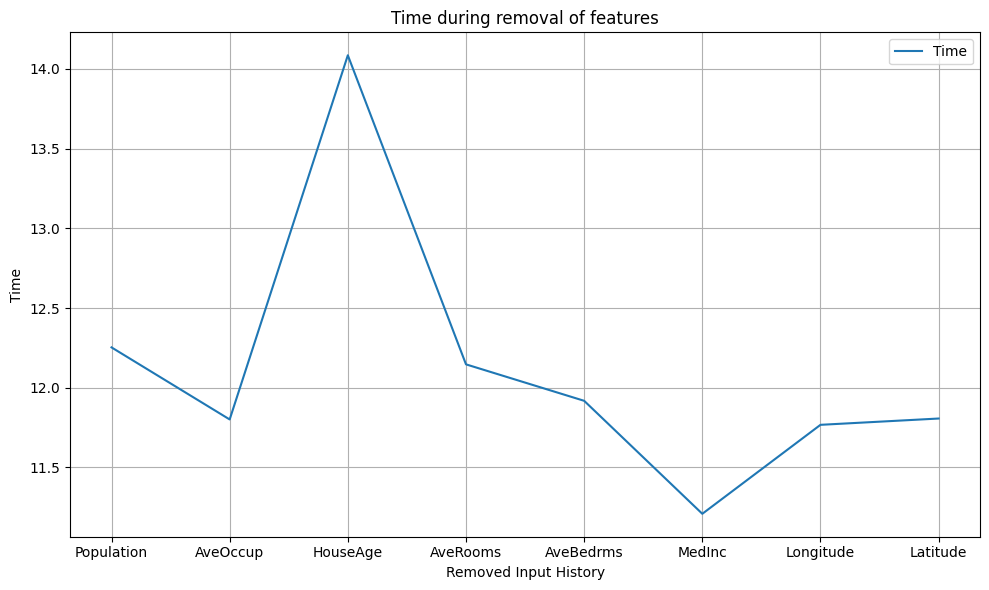

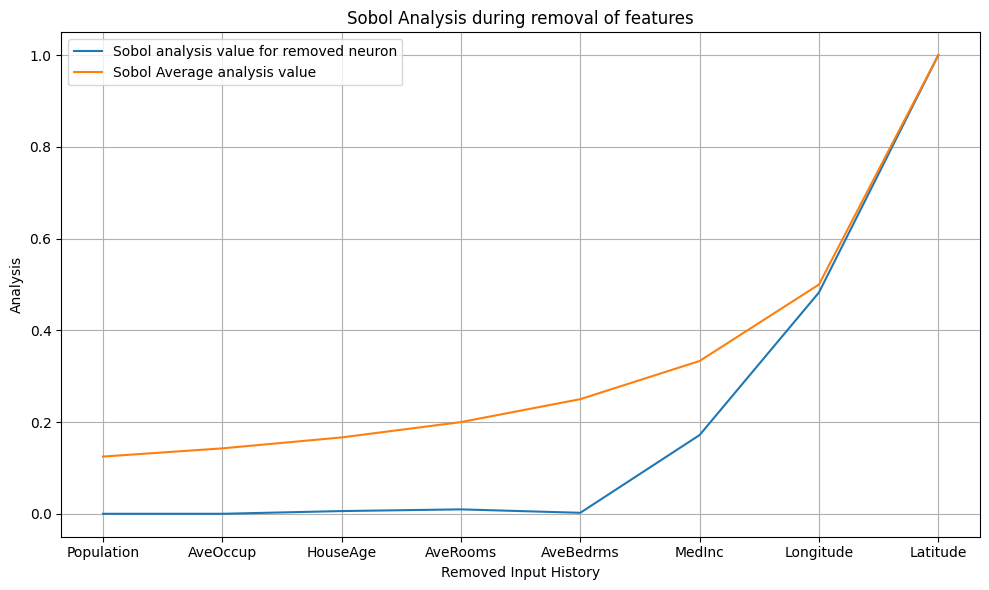

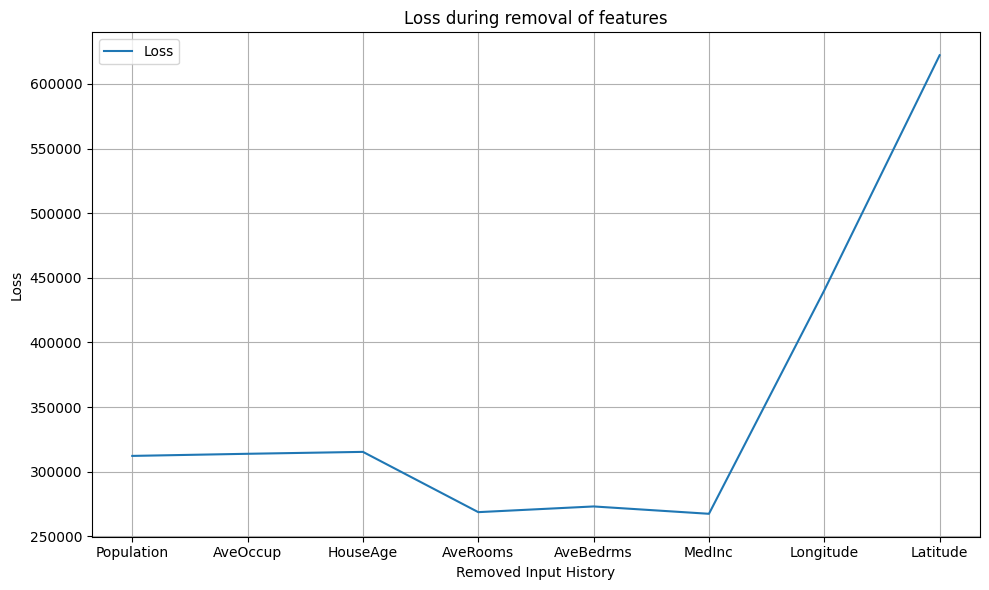

In [ ]:
print("removed_inputs_history:")
print(removed_inputs_history_first_sobol)
print("train_accuracy_history:")
print(train_accuracy_history_first_sobol)
print("valid_accuracy_history:")
print(valid_accuracy_history_first_sobol)
print("test_accuracy_history:")
print(test_accuracy_history_first_sobol)
print("time_history:")
print(time_history_first_sobol)
plot_accuracy(removed_inputs_history_first_sobol, train_accuracy_history_first_sobol, valid_accuracy_history_first_sobol, test_accuracy_history_first_sobol)
plot_time(removed_inputs_history_first_sobol, time_history_first_sobol)
plot_analysis(removed_inputs_history_first_sobol, analysis_history_first_sobol, average_analysis_history_first_sobol, "Sobol")
plot_loss(removed_inputs_history_first_sobol, loss_history)

# Usuwanie neuronów z drugiej warstwy - SOBOL


In [ ]:
housing = fetch_california_housing()

X = pd.DataFrame(housing.data, columns=housing.feature_names)
y = pd.DataFrame(housing.target, columns=housing.target_names)

hidden_dim = 64


removed_inputs_history_second_sobol, train_accuracy_history_second_sobol, valid_accuracy_history_second_sobol, test_accuracy_history_second_sobol, time_history_second_sobol, analysis_history_second_sobol, average_analysis_history_second_sobol = trainWhileRemovingInputsBasedOnAnalysisForSecondLayer(X, y, hidden_dim, AnalysisMethod.SOBOL)

---------------------------------------- Iteration 1 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Loss: -0.0000, Training Accuracy: 0.0001, Valid Accuracy: 0.0000, Test Accuracy: 0.0005
[Sobol] Dropping neuron with index 43 |  Sobol value =  -0.00003 | Avg Sobol value: 0.01568

---------------------------------------- Iteration 2 ----------------------------------------
Loss: -0.0000, Training Accuracy: 0.0001, Valid Accuracy: 0.0000, Test Accuracy: 0.0005
[Sobol] Dropping neuron with index 13 |  Sobol value =  -0.00017 | Avg Sobol value: 0.01589

---------------------------------------- Iteration 3 ----------------------------------------
Loss: -0.0000, Training Accuracy: 0.0001, Valid Accuracy: 0.0000, Test Accuracy: 0.0005
[Sobol] Dropping neuron with index 31 |  Sobol value =  0.00001 | Avg Sobol value: 0.01626

---------------------------------------- Iteration 4 ----------------------------------------
Loss: -0.0000, Training Accuracy: 0.0001, Valid Accuracy: 0.0000, Test Accuracy: 0.0005
[Sobol] Dropping neuron with index 27 |  Sobol value =  -0.00001 | Avg Sobol value: 0.01

removed_inputs_history:
[43, 13, 31, 27, 29, 28, 41, 5, 55, 34, 11, 22, 20, 21, 18, 1, 5, 7, 32, 20, 34, 27, 25, 30, 28, 12, 22, 12, 29, 16, 33, 2, 3, 11, 23, 5, 1, 19, 0, 18, 13, 11, 19, 13, 3, 18, 16, 14, 8, 5, 8, 2, 5, 8, 2, 1, 0, 6, 2, 3, 0, 1, 1, 0]
train_accuracy_history:
[8.074935400516796e-05, 8.074935400516796e-05, 8.074935400516796e-05, 8.074935400516796e-05, 8.074935400516796e-05, 8.074935400516796e-05, 8.074935400516796e-05, 8.074935400516796e-05, 8.074935400516796e-05, 8.074935400516796e-05, 8.074935400516796e-05, 8.074935400516796e-05, 8.074935400516796e-05, 8.074935400516796e-05, 8.074935400516796e-05, 8.074935400516796e-05, 8.074935400516796e-05, 8.074935400516796e-05, 8.074935400516796e-05, 8.074935400516796e-05, 8.074935400516796e-05, 8.074935400516796e-05, 8.074935400516796e-05, 8.074935400516796e-05, 8.074935400516796e-05, 8.074935400516796e-05, 8.074935400516796e-05, 8.074935400516796e-05, 8.074935400516796e-05, 8.074935400516796e-05, 8.074935400516796e-05, 8.07493

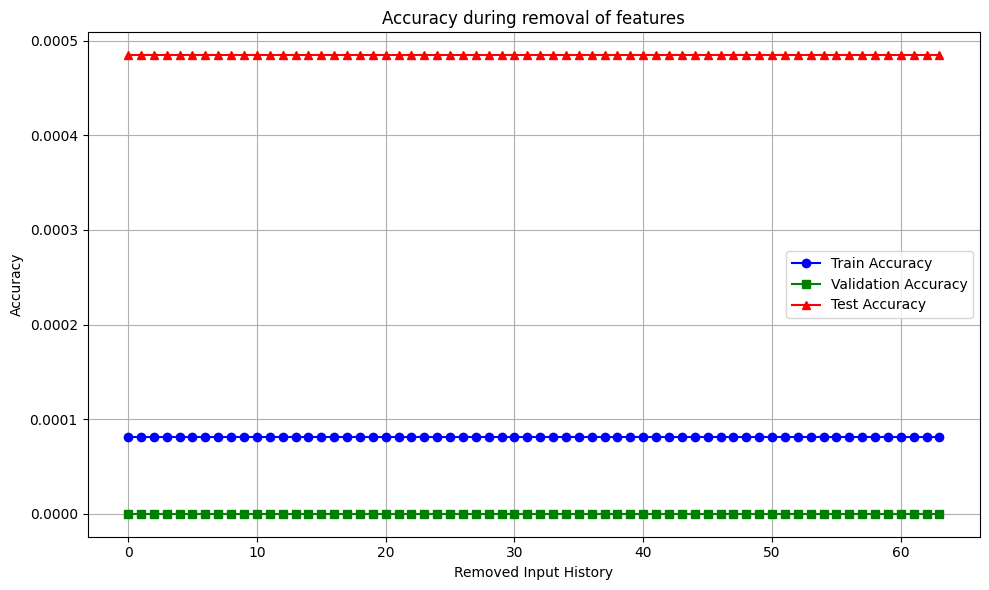

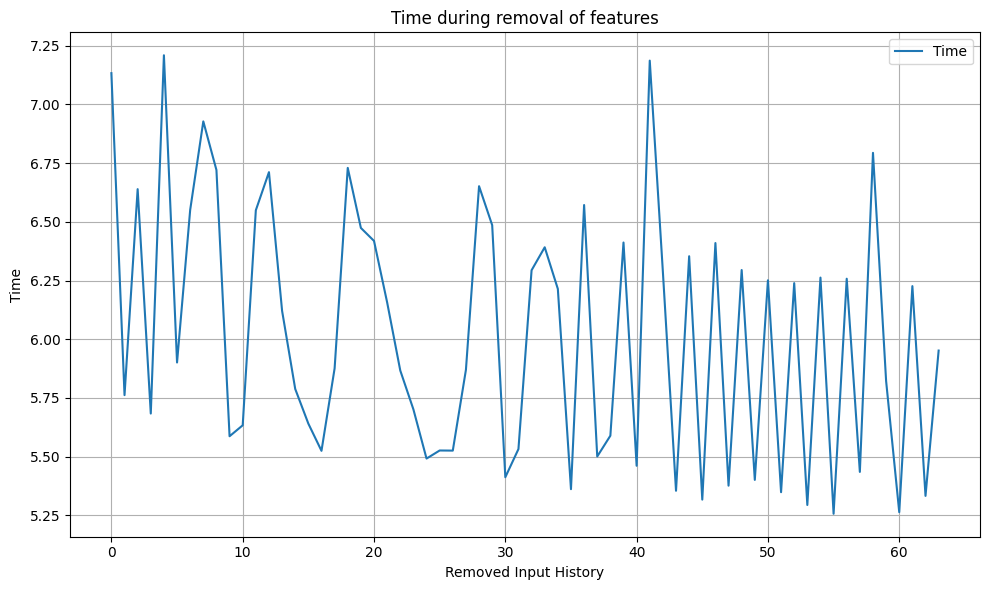

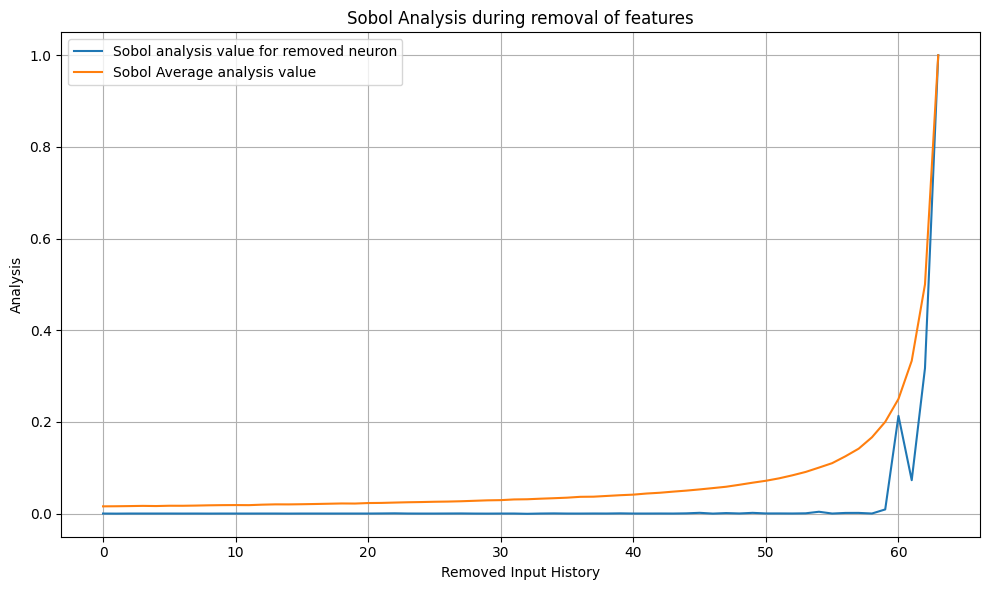

In [ ]:
print("removed_inputs_history:")
print(removed_inputs_history_second_sobol)
print("train_accuracy_history:")
print(train_accuracy_history_second_sobol)
print("valid_accuracy_history:")
print(valid_accuracy_history_second_sobol)
print("test_accuracy_history:")
print(test_accuracy_history_second_sobol)
print("time_history:")
print(time_history_second_sobol)
plot_accuracy(None, train_accuracy_history_second_sobol, valid_accuracy_history_second_sobol, test_accuracy_history_second_sobol)
plot_time(None, time_history_second_sobol)
plot_analysis(None, analysis_history_second_sobol, average_analysis_history_second_sobol, "Sobol")

# Usuwanie neuronów z pierwszej warstwy - PAWN

In [ ]:
housing = fetch_california_housing()

X = pd.DataFrame(housing.data, columns=housing.feature_names)
y = pd.DataFrame(housing.target, columns=housing.target_names)

hidden_dim = 64

removed_inputs_history_first_pawn, train_accuracy_history_first_pawn, valid_accuracy_history_first_pawn, test_accuracy_history_first_pawn, time_history_first_pawn, analysis_history_first_pawn, average_analysis_history_first_pawn, loss_history = trainWhileRemovingInputsBasedOnAnalysisForFirstLayer(X, y, hidden_dim, AnalysisMethod.PAWN)

---------------------------------------- Iteration 1 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Loss: 374855.9062, Training Accuracy: 0.0001, Valid Accuracy: 0.0000, , Test Accuracy: 0.0005
Loss: 325951.7812, Training Accuracy: 0.0001, Valid Accuracy: 0.0000, , Test Accuracy: 0.0005
Loss: 315445.5000, Training Accuracy: 0.0001, Valid Accuracy: 0.0000, , Test Accuracy: 0.0005
Loss: 310833.5938, Training Accuracy: 0.0001, Valid Accuracy: 0.0000, , Test Accuracy: 0.0005
Loss: 309302.1250, Training Accuracy: 0.0001, Valid Accuracy: 0.0000, , Test Accuracy: 0.0005
Loss: 309449.1250, Training Accuracy: 0.0001, Valid Accuracy: 0.0000, , Test Accuracy: 0.0005
Loss: 310357.6250, Training Accuracy: 0.0001, Valid Accuracy: 0.0000, , Test Accuracy: 0.0005
Loss: 311311.5000, Training Accuracy: 0.0001, Valid Accuracy: 0.0000, , Test Accuracy: 0.0005
Loss: 311905.8125, Training Accuracy: 0.0001, Valid Accuracy: 0.0000, , Test Accuracy: 0.0005
Loss: 312104.9688, Training Accuracy: 0.0001, Valid Accuracy: 0.0000, , Test Accuracy: 0.0005
[PAWN] Dropping neuron with index 0 (column: MedInc) |  PAWN

/usr/local/lib/python3.10/dist-packages/SALib/analyze/pawn.py:142: RuntimeWarning: invalid value encountered in scalar divide
  cv = np.nanstd(p_ind) / mean


Loss: 405708.7500, Training Accuracy: 0.0001, Valid Accuracy: 0.0000, , Test Accuracy: 0.0005
Loss: 363583.1250, Training Accuracy: 0.0001, Valid Accuracy: 0.0000, , Test Accuracy: 0.0005
Loss: 352019.2500, Training Accuracy: 0.0001, Valid Accuracy: 0.0000, , Test Accuracy: 0.0005
Loss: 352043.2500, Training Accuracy: 0.0001, Valid Accuracy: 0.0000, , Test Accuracy: 0.0005
Loss: 356535.0000, Training Accuracy: 0.0001, Valid Accuracy: 0.0000, , Test Accuracy: 0.0005
Loss: 361561.4688, Training Accuracy: 0.0001, Valid Accuracy: 0.0000, , Test Accuracy: 0.0005
Loss: 365488.4375, Training Accuracy: 0.0001, Valid Accuracy: 0.0000, , Test Accuracy: 0.0005
Loss: 367961.3750, Training Accuracy: 0.0001, Valid Accuracy: 0.0000, , Test Accuracy: 0.0005
Loss: 369296.0000, Training Accuracy: 0.0001, Valid Accuracy: 0.0000, , Test Accuracy: 0.0005
Loss: 369978.6875, Training Accuracy: 0.0001, Valid Accuracy: 0.0000, , Test Accuracy: 0.0005
[PAWN] Dropping neuron with index 0 (column: HouseAge) |  PA

/usr/local/lib/python3.10/dist-packages/SALib/analyze/pawn.py:142: RuntimeWarning: invalid value encountered in scalar divide
  cv = np.nanstd(p_ind) / mean


Loss: 368789.4375, Training Accuracy: 0.0001, Valid Accuracy: 0.0000, , Test Accuracy: 0.0005
Loss: 317922.3438, Training Accuracy: 0.0001, Valid Accuracy: 0.0000, , Test Accuracy: 0.0005
Loss: 308968.6875, Training Accuracy: 0.0001, Valid Accuracy: 0.0000, , Test Accuracy: 0.0005
Loss: 315416.9375, Training Accuracy: 0.0001, Valid Accuracy: 0.0000, , Test Accuracy: 0.0005
Loss: 324836.2812, Training Accuracy: 0.0001, Valid Accuracy: 0.0000, , Test Accuracy: 0.0005
Loss: 332279.6875, Training Accuracy: 0.0001, Valid Accuracy: 0.0000, , Test Accuracy: 0.0005
Loss: 336899.2500, Training Accuracy: 0.0001, Valid Accuracy: 0.0000, , Test Accuracy: 0.0005
Loss: 339311.7500, Training Accuracy: 0.0001, Valid Accuracy: 0.0000, , Test Accuracy: 0.0005
Loss: 340450.0625, Training Accuracy: 0.0001, Valid Accuracy: 0.0000, , Test Accuracy: 0.0005
Loss: 341001.8750, Training Accuracy: 0.0001, Valid Accuracy: 0.0000, , Test Accuracy: 0.0005
[PAWN] Dropping neuron with index 0 (column: AveRooms) |  PA

/usr/local/lib/python3.10/dist-packages/SALib/analyze/pawn.py:142: RuntimeWarning: invalid value encountered in scalar divide
  cv = np.nanstd(p_ind) / mean


Loss: 482719.9688, Training Accuracy: 0.0001, Valid Accuracy: 0.0000, , Test Accuracy: 0.0005
Loss: 438674.1250, Training Accuracy: 0.0001, Valid Accuracy: 0.0000, , Test Accuracy: 0.0005
Loss: 424468.9375, Training Accuracy: 0.0001, Valid Accuracy: 0.0000, , Test Accuracy: 0.0005
Loss: 421559.1562, Training Accuracy: 0.0001, Valid Accuracy: 0.0000, , Test Accuracy: 0.0005
Loss: 424808.7500, Training Accuracy: 0.0001, Valid Accuracy: 0.0000, , Test Accuracy: 0.0005
Loss: 430852.3750, Training Accuracy: 0.0001, Valid Accuracy: 0.0000, , Test Accuracy: 0.0005
Loss: 437360.9688, Training Accuracy: 0.0001, Valid Accuracy: 0.0000, , Test Accuracy: 0.0005
Loss: 442799.1875, Training Accuracy: 0.0001, Valid Accuracy: 0.0000, , Test Accuracy: 0.0005
Loss: 446520.9375, Training Accuracy: 0.0001, Valid Accuracy: 0.0000, , Test Accuracy: 0.0005
Loss: 448725.0312, Training Accuracy: 0.0001, Valid Accuracy: 0.0000, , Test Accuracy: 0.0005
[PAWN] Dropping neuron with index 0 (column: AveBedrms) |  P

/usr/local/lib/python3.10/dist-packages/SALib/analyze/pawn.py:142: RuntimeWarning: invalid value encountered in scalar divide
  cv = np.nanstd(p_ind) / mean


Loss: 474733.9688, Training Accuracy: 0.0001, Valid Accuracy: 0.0000, , Test Accuracy: 0.0005
Loss: 432200.5000, Training Accuracy: 0.0001, Valid Accuracy: 0.0000, , Test Accuracy: 0.0005
Loss: 420378.1562, Training Accuracy: 0.0001, Valid Accuracy: 0.0000, , Test Accuracy: 0.0005
Loss: 420537.4062, Training Accuracy: 0.0001, Valid Accuracy: 0.0000, , Test Accuracy: 0.0005
Loss: 425771.0938, Training Accuracy: 0.0001, Valid Accuracy: 0.0000, , Test Accuracy: 0.0005
Loss: 431976.7812, Training Accuracy: 0.0001, Valid Accuracy: 0.0000, , Test Accuracy: 0.0005
Loss: 437025.8750, Training Accuracy: 0.0001, Valid Accuracy: 0.0000, , Test Accuracy: 0.0005
Loss: 440306.5938, Training Accuracy: 0.0001, Valid Accuracy: 0.0000, , Test Accuracy: 0.0005
Loss: 442175.3125, Training Accuracy: 0.0001, Valid Accuracy: 0.0000, , Test Accuracy: 0.0005
Loss: 443198.1562, Training Accuracy: 0.0001, Valid Accuracy: 0.0000, , Test Accuracy: 0.0005
[PAWN] Dropping neuron with index 0 (column: Population) |  

/usr/local/lib/python3.10/dist-packages/SALib/analyze/pawn.py:142: RuntimeWarning: invalid value encountered in scalar divide
  cv = np.nanstd(p_ind) / mean


Loss: 472211.0000, Training Accuracy: 0.0001, Valid Accuracy: 0.0000, , Test Accuracy: 0.0005
Loss: 430303.1562, Training Accuracy: 0.0001, Valid Accuracy: 0.0000, , Test Accuracy: 0.0005
Loss: 418648.6875, Training Accuracy: 0.0001, Valid Accuracy: 0.0000, , Test Accuracy: 0.0005
Loss: 419093.8125, Training Accuracy: 0.0001, Valid Accuracy: 0.0000, , Test Accuracy: 0.0005
Loss: 424434.1250, Training Accuracy: 0.0001, Valid Accuracy: 0.0000, , Test Accuracy: 0.0005
Loss: 430421.8750, Training Accuracy: 0.0001, Valid Accuracy: 0.0000, , Test Accuracy: 0.0005
Loss: 435038.8125, Training Accuracy: 0.0001, Valid Accuracy: 0.0000, , Test Accuracy: 0.0005
Loss: 437934.6875, Training Accuracy: 0.0001, Valid Accuracy: 0.0000, , Test Accuracy: 0.0005
Loss: 439592.9375, Training Accuracy: 0.0001, Valid Accuracy: 0.0000, , Test Accuracy: 0.0005
Loss: 440515.6562, Training Accuracy: 0.0001, Valid Accuracy: 0.0000, , Test Accuracy: 0.0005
[PAWN] Dropping neuron with index 0 (column: AveOccup) |  PA

/usr/local/lib/python3.10/dist-packages/SALib/analyze/pawn.py:142: RuntimeWarning: invalid value encountered in scalar divide
  cv = np.nanstd(p_ind) / mean


Loss: 472757.5625, Training Accuracy: 0.0001, Valid Accuracy: 0.0000, , Test Accuracy: 0.0005
Loss: 428443.8750, Training Accuracy: 0.0001, Valid Accuracy: 0.0000, , Test Accuracy: 0.0005
Loss: 426980.2500, Training Accuracy: 0.0001, Valid Accuracy: 0.0000, , Test Accuracy: 0.0005
Loss: 433162.0938, Training Accuracy: 0.0001, Valid Accuracy: 0.0000, , Test Accuracy: 0.0005
Loss: 436689.4375, Training Accuracy: 0.0001, Valid Accuracy: 0.0000, , Test Accuracy: 0.0005
Loss: 438122.8438, Training Accuracy: 0.0001, Valid Accuracy: 0.0000, , Test Accuracy: 0.0005
Loss: 438666.5000, Training Accuracy: 0.0001, Valid Accuracy: 0.0000, , Test Accuracy: 0.0005
Loss: 438876.4062, Training Accuracy: 0.0001, Valid Accuracy: 0.0000, , Test Accuracy: 0.0005
Loss: 438963.1250, Training Accuracy: 0.0001, Valid Accuracy: 0.0000, , Test Accuracy: 0.0005
Loss: 439003.9375, Training Accuracy: 0.0001, Valid Accuracy: 0.0000, , Test Accuracy: 0.0005
[PAWN] Dropping neuron with index 0 (column: Latitude) |  PA

/usr/local/lib/python3.10/dist-packages/SALib/analyze/pawn.py:142: RuntimeWarning: invalid value encountered in scalar divide
  cv = np.nanstd(p_ind) / mean


Loss: 595291.1875, Training Accuracy: 0.0001, Valid Accuracy: 0.0000, , Test Accuracy: 0.0005
Loss: 596704.1875, Training Accuracy: 0.0001, Valid Accuracy: 0.0000, , Test Accuracy: 0.0005
Loss: 597186.8750, Training Accuracy: 0.0001, Valid Accuracy: 0.0000, , Test Accuracy: 0.0005
Loss: 597389.2500, Training Accuracy: 0.0001, Valid Accuracy: 0.0000, , Test Accuracy: 0.0005
Loss: 597478.5000, Training Accuracy: 0.0001, Valid Accuracy: 0.0000, , Test Accuracy: 0.0005
Loss: 597518.5000, Training Accuracy: 0.0001, Valid Accuracy: 0.0000, , Test Accuracy: 0.0005
Loss: 597536.6250, Training Accuracy: 0.0001, Valid Accuracy: 0.0000, , Test Accuracy: 0.0005
Loss: 597544.7500, Training Accuracy: 0.0001, Valid Accuracy: 0.0000, , Test Accuracy: 0.0005
Loss: 597548.3125, Training Accuracy: 0.0001, Valid Accuracy: 0.0000, , Test Accuracy: 0.0005
Loss: 597549.8125, Training Accuracy: 0.0001, Valid Accuracy: 0.0000, , Test Accuracy: 0.0005
[PAWN] Dropping neuron with index 0 (column: Longitude) |  P

/usr/local/lib/python3.10/dist-packages/SALib/analyze/pawn.py:142: RuntimeWarning: invalid value encountered in scalar divide
  cv = np.nanstd(p_ind) / mean


removed_inputs_history:
['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']
train_accuracy_history:
[8.074935400516796e-05, 8.074935400516796e-05, 8.074935400516796e-05, 8.074935400516796e-05, 8.074935400516796e-05, 8.074935400516796e-05, 8.074935400516796e-05, 8.074935400516796e-05]
valid_accuracy_history:
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
test_accuracy_history:
[0.00048449612403100775, 0.00048449612403100775, 0.00048449612403100775, 0.00048449612403100775, 0.00048449612403100775, 0.00048449612403100775, 0.00048449612403100775, 0.00048449612403100775]
time_history:
[13.694212436676025, 11.612212896347046, 11.740698337554932, 11.68082332611084, 11.548672199249268, 10.929791450500488, 11.14858102798462, 11.651707410812378]


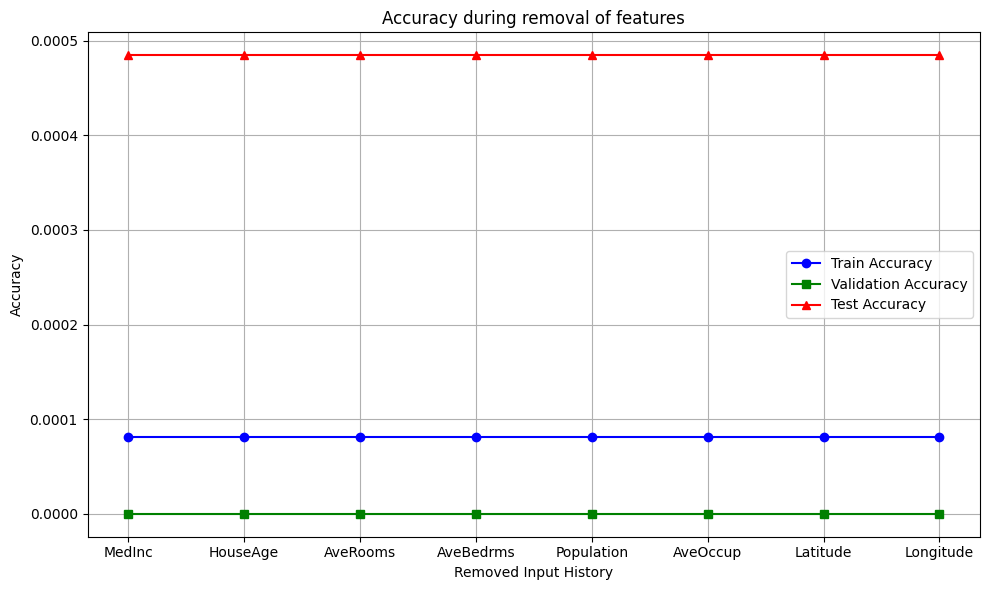

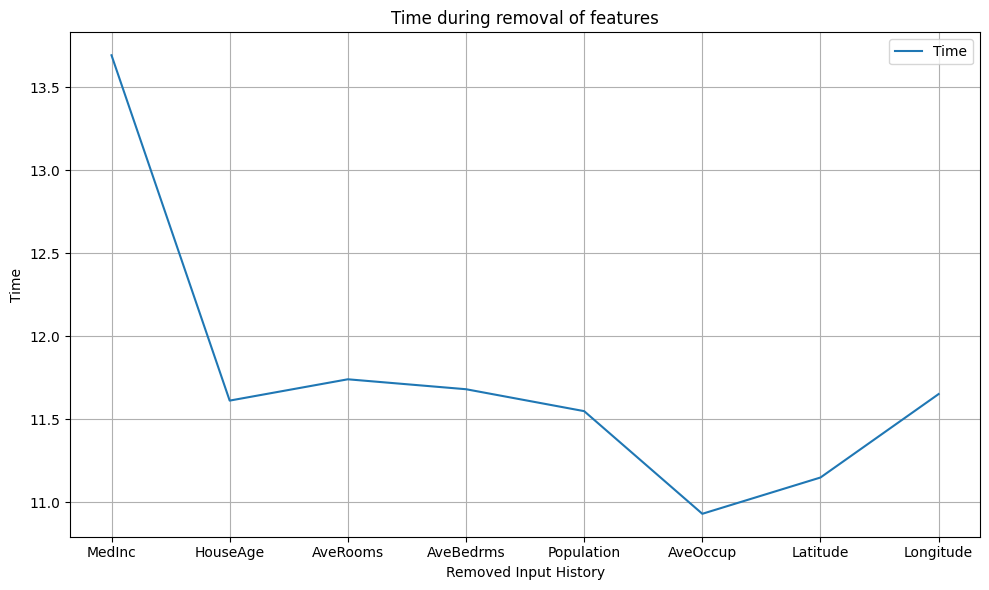

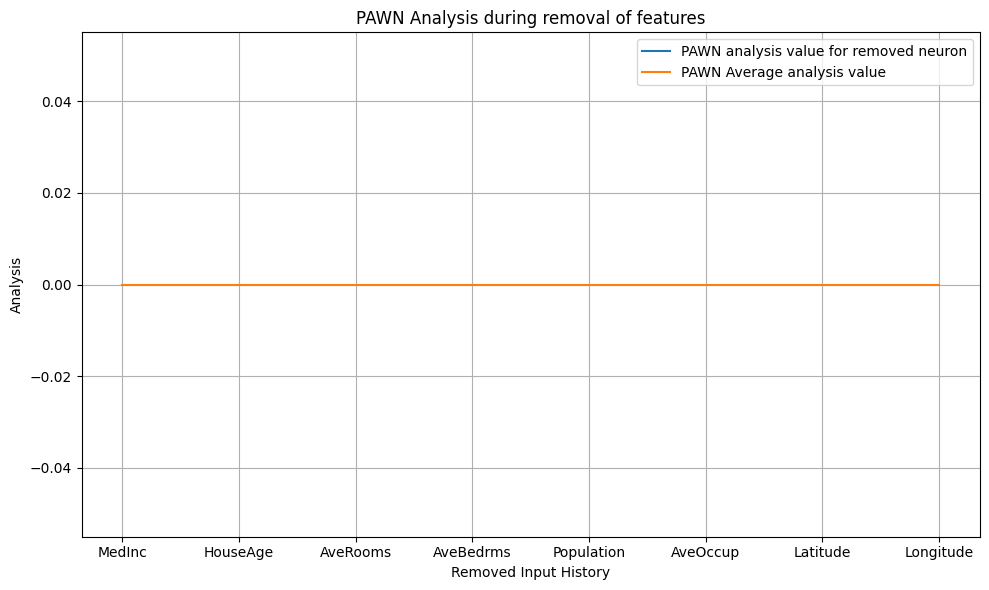

In [ ]:
print("removed_inputs_history:")
print(removed_inputs_history_first_pawn)
print("train_accuracy_history:")
print(train_accuracy_history_first_pawn)
print("valid_accuracy_history:")
print(valid_accuracy_history_first_pawn)
print("test_accuracy_history:")
print(test_accuracy_history_first_pawn)
print("time_history:")
print(time_history_first_pawn)
plot_accuracy(removed_inputs_history_first_pawn, train_accuracy_history_first_pawn, valid_accuracy_history_first_pawn, test_accuracy_history_first_pawn)
plot_time(removed_inputs_history_first_pawn, time_history_first_pawn)
plot_analysis(removed_inputs_history_first_pawn, analysis_history_first_pawn, average_analysis_history_first_pawn, "PAWN")

# Usuwanie neuronów z drugiej warstwy - PAWN

In [ ]:
housing = fetch_california_housing()

X = pd.DataFrame(housing.data, columns=housing.feature_names)
y = pd.DataFrame(housing.target, columns=housing.target_names)

hidden_dim = 64


#droping useless inputs -example
X = X.drop('Sweetness', axis=1)
X = X.drop('Ripeness', axis=1)


removed_inputs_history_second_pawn, train_accuracy_history_second_pawn, valid_accuracy_history_second_pawn, test_accuracy_history_second_pawn, time_history_second_pawn, analysis_history_second_pawn, average_analysis_history_second_pawn = trainWhileRemovingInputsBasedOnAnalysisForSecondLayer(X, y, hidden_dim, AnalysisMethod.PAWN)

KeyError: "['Sweetness'] not found in axis"

In [ ]:
print("removed_inputs_history:")
print(removed_inputs_history_second_pawn)
print("train_accuracy_history:")
print(train_accuracy_history_second_pawn)
print("valid_accuracy_history:")
print(valid_accuracy_history_second_pawn)
print("test_accuracy_history:")
print(test_accuracy_history_second_pawn)
print("time_history:")
print(time_history_second_pawn)
plot_accuracy(None, train_accuracy_history_second_pawn, valid_accuracy_history_second_pawn, test_accuracy_history_second_pawn)
plot_time(None, time_history_second_pawn)
plot_analysis(None, analysis_history_second_pawn, average_analysis_history_second_pawn, "PAWN")

removed_inputs_history:


NameError: name 'removed_inputs_history_second_pawn' is not defined